# 任务描述：
社交媒体的发展在加速信息传播的同时，也带来了虚假谣言信息的泛滥，往往会引发诸多不安定因素，并对经济和社会产生巨大的影响。

2016年美国总统大选期间，受访选民平均每人每天接触到4篇虚假新闻，虚假新闻被认为影响了2016年美国大选和英国脱欧的投票结果；近期，在新型冠状病毒感染的肺炎疫情防控的关键期，在全国人民都为疫情揪心时，网上各种有关疫情防控的谣言接连不断，从“广州公交线路因新型冠状病毒肺炎疫情停运”到“北京市为防控疫情采取封城措施”，从“钟南山院士被感染”到“10万人感染肺炎”等等，这些不切实际的谣言，“操纵”了舆论感情，误导了公众的判断，更影响了社会稳定。

人们常说“流言止于智者”，要想不被网上的流言和谣言盅惑、伤害，首先需要对其进行科学甄别，而时下人工智能正在尝试担任这一角色。那么，在打假一线AI技术如何做到去伪存真？

传统的谣言检测模型一般根据谣言的内容、用户属性、传播方式人工地构造特征，而人工构建特征存在考虑片面、浪费人力等现象。本次实践使用基于循环神经网络（RNN）的谣言检测模型，将文本中的谣言事件向量化，通过循环神经网络的学习训练来挖掘表示文本深层的特征，避免了特征构建的问题，并能发现那些不容易被人发现的特征，从而产生更好的效果。

数据集介绍：

本次实践所使用的数据是从新浪微博不实信息举报平台抓取的中文谣言数据，数据集中共包含1538条谣言和1849条非谣言。如下图所示，每条数据均为json格式，其中text字段代表微博原文的文字内容。

更多数据集介绍请参考https://github.com/thunlp/Chinese_Rumor_Dataset。

![](https://ai-studio-static-online.cdn.bcebos.com/30665456670941acaf0ad4bfa78252e8d44f296dda8d48dea2ada26a5f10ef1a)

# 一、环境设置
本示例基于飞桨开源框架2.0版本。

In [12]:
import paddle
import numpy as np
import matplotlib.pyplot as plt
print(paddle.__version__)

2.0.2


# 二、数据准备

（1）解压数据，读取并解析数据，生成all_data.txt

（2）生成数据字典，即dict.txt

（3）生成数据列表，并进行训练集与验证集的划分，train_list.txt 、eval_list.txt

（4）定义训练数据集提供器

In [13]:
import os, zipfile
src_path="data/data20519/Rumor_Dataset.zip"
target_path="/home/aistudio/data/Chinese_Rumor_Dataset-master"
if(not os.path.isdir(target_path)):
    z = zipfile.ZipFile(src_path, 'r')
    z.extractall(path=target_path)
    z.close()

In [14]:
import io
import random
import json


#谣言数据文件路径
rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/rumor-repost/")

#非谣言数据文件路径
non_rumor_class_dirs = os.listdir(target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/non-rumor-repost/")

original_microblog = target_path+"/Chinese_Rumor_Dataset-master/CED_Dataset/original-microblog/"

#谣言标签为0，非谣言标签为1
rumor_label="0"
non_rumor_label="1"

#分别统计谣言数据与非谣言数据的总数
rumor_num = 0
non_rumor_num = 0

all_rumor_list = []
all_non_rumor_list = []

#解析谣言数据
for rumor_class_dir in rumor_class_dirs: 
    if(rumor_class_dir != '.DS_Store'):
        #遍历谣言数据，并解析
        with open(original_microblog + rumor_class_dir, 'r') as f:
	        rumor_content = f.read()
        rumor_dict = json.loads(rumor_content)
        all_rumor_list.append(rumor_label+"\t"+rumor_dict["text"]+"\n")
        rumor_num +=1

#解析非谣言数据
for non_rumor_class_dir in non_rumor_class_dirs: 
    if(non_rumor_class_dir != '.DS_Store'):
        with open(original_microblog + non_rumor_class_dir, 'r') as f2:
	        non_rumor_content = f2.read()
        non_rumor_dict = json.loads(non_rumor_content)
        all_non_rumor_list.append(non_rumor_label+"\t"+non_rumor_dict["text"]+"\n")
        non_rumor_num +=1
        
print("谣言数据总量为："+str(rumor_num))
print("非谣言数据总量为："+str(non_rumor_num))

谣言数据总量为：1538
非谣言数据总量为：1849


In [24]:
#全部数据进行乱序后写入all_data.txt

data_list_path="/home/aistudio/data/"
all_data_path=data_list_path + "all_data.txt"

all_data_list = all_rumor_list + all_non_rumor_list

random.shuffle(all_data_list)

#在生成all_data.txt之前，首先将其清空
with open(all_data_path, 'w') as f:
    f.seek(0)
    f.truncate() 
    
with open(all_data_path, 'a') as f:
    for data in all_data_list:
        f.write(data) 

In [25]:
# 生成数据字典
def create_dict(data_path, dict_path):
    with open(dict_path, 'w') as f:
        f.seek(0)
        f.truncate() 

    dict_set = set()
    # 读取全部数据
    with open(data_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 把数据生成一个元组
    for line in lines:
        content = line.split('\t')[-1].replace('\n', '')
        for s in content:
            dict_set.add(s)
    # 把元组转换成字典，一个字对应一个数字
    dict_list = []
    i = 0
    for s in dict_set:
        dict_list.append([s, i])
        i += 1
    # 添加未知字符
    dict_txt = dict(dict_list)
    end_dict = {"<unk>": i}
    dict_txt.update(end_dict)
    end_dict = {"<pad>": i+1}
    dict_txt.update(end_dict)
    # 把这些字典保存到本地中
    with open(dict_path, 'w', encoding='utf-8') as f:
        f.write(str(dict_txt))

        
    print("数据字典生成完成！")


In [26]:
# 创建序列化表示的数据,并按照一定比例划分训练数据train_list.txt与验证数据eval_list.txt
def create_data_list(data_list_path):
    #在生成数据之前，首先将eval_list.txt和train_list.txt清空
    with open(os.path.join(data_list_path, 'eval_list.txt'), 'w', encoding='utf-8') as f_eval:
        f_eval.seek(0)
        f_eval.truncate()
        
    with open(os.path.join(data_list_path, 'train_list.txt'), 'w', encoding='utf-8') as f_train:
        f_train.seek(0)
        f_train.truncate() 
    
    with open(os.path.join(data_list_path, 'dict.txt'), 'r', encoding='utf-8') as f_data:
        dict_txt = eval(f_data.readlines()[0])

    with open(os.path.join(data_list_path, 'all_data.txt'), 'r', encoding='utf-8') as f_data:
        lines = f_data.readlines()
    
    i = 0
    maxlen = 0
    with open(os.path.join(data_list_path, 'eval_list.txt'), 'a', encoding='utf-8') as f_eval,open(os.path.join(data_list_path, 'train_list.txt'), 'a', encoding='utf-8') as f_train:
        for line in lines:
            words = line.split('\t')[-1].replace('\n', '')
            maxlen = max(maxlen, len(words))
            label = line.split('\t')[0]
            labs = ""
            # 每8个 抽取一个数据用于验证
            if i % 8 == 0:
                for s in words:
                    lab = str(dict_txt[s])
                    labs = labs + lab + ','
                labs = labs[:-1]
                labs = labs + '\t' + label + '\n'
                f_eval.write(labs)
            else:
                for s in words:
                    lab = str(dict_txt[s])
                    labs = labs + lab + ','
                labs = labs[:-1]
                labs = labs + '\t' + label + '\n'
                f_train.write(labs)
            i += 1
        
    print("数据列表生成完成！")
    print("样本最长长度：" + str(maxlen))

In [27]:
# 把生成的数据列表都放在自己的总类别文件夹中
data_root_path = "/home/aistudio/data/" 
data_path = os.path.join(data_root_path, 'all_data.txt')
dict_path = os.path.join(data_root_path, "dict.txt")

# 创建数据字典
create_dict(data_path, dict_path)

# 创建数据列表
create_data_list(data_root_path)

数据字典生成完成！
数据列表生成完成！
样本最长长度：226


In [19]:
def load_vocab(file_path):
    fr = open(file_path, 'r', encoding='utf8')
    vocab = eval(fr.read())   #读取的str转换为字典
    fr.close()

    return vocab

In [28]:
# 打印前2条训练数据
vocab = load_vocab(os.path.join(data_root_path, 'dict.txt'))

def ids_to_str(ids):
    words = []
    for k in ids:
        w = list(vocab.keys())[list(vocab.values()).index(int(k))]
        words.append(w if isinstance(w, str) else w.decode('ASCII'))
    return " ".join(words)

file_path = os.path.join(data_root_path, 'train_list.txt')
with io.open(file_path, "r", encoding='utf8') as fin:
        i = 0
        for line in fin:
            i += 1
            cols = line.strip().split("\t")
            if len(cols) != 2:
                sys.stderr.write("[NOTICE] Error Format Line!")
                continue
            label = int(cols[1])
            wids = cols[0].split(",")
            print(str(i)+":")
            print('sentence list id is:', wids)
            print('sentence list is: ', ids_to_str(wids))
            print('sentence label id is:', label)
            print('---------------------------------')
            
            if i == 2: break

1:
sentence list id is: ['177', '1679', '1504', '1705', '621', '3382', '2161', '3470', '3135', '4406', '323', '4381', '2514', '536', '2930', '2275', '3300', '3343', '1349', '1738', '1222', '3325', '1159', '2893', '243', '1084', '1411', '3808', '494', '13', '241', '1575', '1613', '2801', '3199', '3343', '3382', '2161', '241', '3199', '3343', '570', '1613', '2614', '1705', '473', '1905', '3768', '1524', '232', '1575', '2577', '2545', '1575', '2577', '115', '2801', '335', '1673', '3382', '2161', '241', '335', '1673', '1705', '570', '473', '1905', '3768', '1524', '232', '1575', '2577', '2545', '1575', '2577', '2577', '2801', '4265', '3343', '3382', '2161', '241', '4265', '3343', '570', '3998', '473', '1905', '3768', '1524', '232', '1575', '2577', '2545', '690', '3559', '3275', '2801', '3382', '2161', '4231', '1250', '3127', '3478', '1272', '435', '3135', '1672', '2915', '1080', '2889', '1770', '4251', '4256', '1669', '985', '1705', '621', '3382', '2161', '4231', '985', '3343', '1349', '173

In [29]:

vocab = load_vocab(os.path.join(data_root_path, 'dict.txt'))

class RumorDataset(paddle.io.Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.all_data = []
       
        with io.open(self.data_dir, "r", encoding='utf8') as fin:
            for line in fin:
                cols = line.strip().split("\t")
                if len(cols) != 2:
                    sys.stderr.write("[NOTICE] Error Format Line!")
                    continue
                label = []
                label.append(int(cols[1]))
                wids = cols[0].split(",")
                if len(wids)>=150:
                    wids = np.array(wids[:150]).astype('int64')     
                else:
                    wids = np.concatenate([wids, [vocab["<pad>"]]*(150-len(wids))]).astype('int64')
                label = np.array(label).astype('int64')
                self.all_data.append((wids, label))

        
    def __getitem__(self, index):
        data, label = self.all_data[index]
        return data, label

    def __len__(self):
        return len(self.all_data)


batch_size = 32
train_dataset = RumorDataset(os.path.join(data_root_path, 'train_list.txt'))
test_dataset = RumorDataset(os.path.join(data_root_path, 'eval_list.txt'))

train_loader = paddle.io.DataLoader(train_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)




#check

print('=============train_dataset =============') 
for data, label in train_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break


print('=============test_dataset =============') 
for data, label in test_dataset:
    print(data)
    print(np.array(data).shape)
    print(label)
    break




=============train_dataset =============
[ 177 1679 1504 1705  621 3382 2161 3470 3135 4406  323 4381 2514  536
 2930 2275 3300 3343 1349 1738 1222 3325 1159 2893  243 1084 1411 3808
  494   13  241 1575 1613 2801 3199 3343 3382 2161  241 3199 3343  570
 1613 2614 1705  473 1905 3768 1524  232 1575 2577 2545 1575 2577  115
 2801  335 1673 3382 2161  241  335 1673 1705  570  473 1905 3768 1524
  232 1575 2577 2545 1575 2577 2577 2801 4265 3343 3382 2161  241 4265
 3343  570 3998  473 1905 3768 1524  232 1575 2577 2545  690 3559 3275
 2801 3382 2161 4231 1250 3127 3478 1272  435 3135 1672 2915 1080 2889
 1770 4251 4256 1669  985 1705  621 3382 2161 4231  985 3343 1349 1738
 3709 1222 3325  928 2233 1159 2893  243 1409 3382 1669  985 3300 1319
 3757 3757 1882 3470 1143 1143 3757 2614 2444 3543]
(150,)
[1]
=============test_dataset =============
[ 177   54 3465 3543 2137 4322  669  754   41  290 2016 2517 3629 3270
 3300 2129 3055  985  950  940 2908 3234  634  850 2599 2577  115 2369
 385

# 三、模型配置

In [31]:
import paddle
from paddle.nn import Conv2D, Linear, Embedding
from paddle import to_tensor
import paddle.nn.functional as F

class RNN(paddle.nn.Layer):
    def __init__(self):
        super(RNN, self).__init__()
        self.dict_dim = vocab["<pad>"]
        self.emb_dim = 128
        self.hid_dim = 128
        self.class_dim = 2
        self.embedding = Embedding(
            self.dict_dim + 1, self.emb_dim,
            sparse=False)
        self._fc1 = Linear(self.emb_dim, self.hid_dim)
        self.lstm = paddle.nn.LSTM(self.hid_dim, self.hid_dim)
        self.fc2 = Linear(19200, self.class_dim)

    def forward(self, inputs):
        # [32, 150]
        emb = self.embedding(inputs)
        # [32, 150, 128]
        fc_1 = self._fc1(emb)
        # [32, 150, 128]
        x = self.lstm(fc_1)
        x = paddle.reshape(x[0], [0, -1])
        x = self.fc2(x)
        x = paddle.nn.functional.softmax(x)
        return x

rnn = RNN()
paddle.summary(rnn,(32,150),"int64")

-----------------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                       Output Shape                      Param #    
  Embedding-2       [[32, 150]]                      [32, 150, 128]                     564,608    
   Linear-3       [[32, 150, 128]]                   [32, 150, 128]                     16,512     
    LSTM-2        [[32, 150, 128]]   [[32, 150, 128], [[1, 32, 128], [1, 32, 128]]]     132,096    
   Linear-4        [[32, 19200]]                        [32, 2]                         38,402     
Total params: 751,618
Trainable params: 751,618
Non-trainable params: 0
-----------------------------------------------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 142.06
Params size (MB): 2.87
Estimated Total Size (MB): 144.95
-----------------------------------------------------------------------------------------------------



{'total_params': 751618, 'trainable_params': 751618}

# 四、模型训练

In [32]:
def draw_process(title,color,iters,data,label):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(iters, data,color=color,label=label) 
    plt.legend()
    plt.grid()
    plt.show()

epoch: 0, batch_id: 0, loss is: [0.68715864]
epoch: 0, batch_id: 50, loss is: [0.54819226]
[validation] accuracy: 0.8605769276618958, loss: 0.4531055688858032
epoch: 1, batch_id: 0, loss is: [0.5612684]
epoch: 1, batch_id: 50, loss is: [0.40336296]
[validation] accuracy: 0.807692289352417, loss: 0.497310996055603
epoch: 2, batch_id: 0, loss is: [0.39833498]
epoch: 2, batch_id: 50, loss is: [0.37105706]
[validation] accuracy: 0.7788461446762085, loss: 0.520526111125946


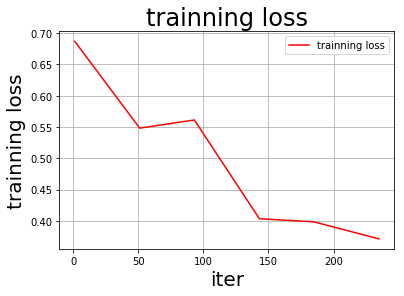

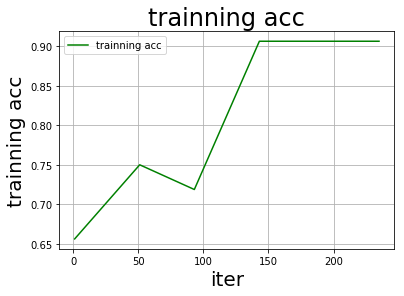

In [34]:
def train(model):
    model.train()
    opt = paddle.optimizer.Adam(learning_rate=0.002, parameters=model.parameters())
    
    steps = 0
    Iters, total_loss, total_acc = [], [], []
    
    for epoch in range(3):
        for batch_id, data in enumerate(train_loader):
            steps += 1
            sent = data[0]
            label = data[1]
            
            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)

            if batch_id % 50 == 0:
                Iters.append(steps)
                total_loss.append(loss.numpy()[0])
                total_acc.append(acc.numpy()[0])

                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss.numpy()))
            
            loss.backward()
            opt.step()
            opt.clear_grad()

        # evaluate model after one epoch
        model.eval()
        accuracies = []
        losses = []
        
        for batch_id, data in enumerate(test_loader):
            
            sent = data[0]
            label = data[1]

            logits = model(sent)
            loss = paddle.nn.functional.cross_entropy(logits, label)
            acc = paddle.metric.accuracy(logits, label)
            
            accuracies.append(acc.numpy())
            losses.append(loss.numpy())
        
        avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)

        print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
        
        model.train()

    paddle.save(model.state_dict(),"model_final.pdparams")
    
    draw_process("trainning loss","red",Iters,total_loss,"trainning loss")
    draw_process("trainning acc","green",Iters,total_acc,"trainning acc")
        
model = RNN()
train(model)

# 五、模型评估

In [39]:
'''
模型评估
'''
model_state_dict = paddle.load('model_final.pdparams')
model = RNN()
model.set_state_dict(model_state_dict) 
model.eval()
label_map = {0:"是", 1:"否"}
samples = []
predictions = []
accuracies = []
losses = []

for batch_id, data in enumerate(test_loader):
    
    sent = data[0]
    label = data[1]

    logits = model(sent)

    for idx,probs in enumerate(logits):
        # 映射分类label
        label_idx = np.argmax(probs)
        labels = label_map[label_idx]
        predictions.append(labels)
        samples.append(sent[idx].numpy())
    
    loss = paddle.nn.functional.cross_entropy(logits, label)
    acc = paddle.metric.accuracy(logits, label)
    
    accuracies.append(acc.numpy())
    losses.append(loss.numpy())

avg_acc, avg_loss = np.mean(accuracies), np.mean(losses)
print("[validation] accuracy: {}, loss: {}".format(avg_acc, avg_loss))
print('数据: {} \n\n是否谣言: {}'.format(ids_to_str(samples[0]), predictions[0]))

[validation] accuracy: 0.7788461446762085, loss: 0.5199828743934631
数据: 【 上 海 大 学 一 学 院 男 生 被 室 友 捅 伤 致 死 】 1 2 日 ， 上 海 大 学 巴 士 汽 车 学 院 内 发 生 血 案 ， 警 方 接 报 赶 往 现 场 将 一 持 刀 捅 伤 室 友 的 2 1 岁 男 生 汤 某 控 制 ， 2 0 岁 伤 者 聂 某 送 医 抢 救 无 效 死 亡 。 汤 某 被 刑 拘 。 案 发 寝 室 内 ， 两 男 生 非 同 专 业 ， 或 因 琐 事 争 吵 而 肢 体 冲 突 ， 汤 某 用 一 把 小 刀 捅 伤 聂 某 。 综 合 新 华 、 新 民 网 h t t p : / / t . c n / 8 D D Q t 

是否谣言: 是
